# BirdCLEF 2025 Exploratory Data Analysis

Notebook phục vụ cho việc phân tích và hiểu dữ liệu:
1. Thời lượng trung bình của các bản ghi
2. Phân bố số lượng bản ghi của mỗi loài
3. Khảo sát chất lượng bản ghi
5. Một số biểu diễn âm thanh của các bản ghi

## Setup and Configuration

Import các thư viện cần thiết:
- `librosa` cho xử lý âm thanh
- `pandas` cho xử lý dữ liệu bảng
- `matplotlib`, `seaborn`, và `plotly` cho trực quan hóa
- `scipy` xử lý tín hiệu

In [ ]:
import pandas as pd
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter, defaultdict
from scipy import stats
from scipy.signal import periodogram

warnings.filterwarnings('ignore')

# Cài đặt hiển thị
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")
%matplotlib inline

## Configuration Class

Cài đặt một số config cố định

In [ ]:
class Config:
    # Test
    DEBUG_MODE = False 
    VISUALIZE = True   # Có muốn hiển thị visual
    SAMPLE_SIZE = 100  # Số lượng file muốn test
    
    # Paths
    BASE_DIR = '/kaggle/input/birdclef-2025/'  
    TRAIN_AUDIO_DIR = os.path.join(BASE_DIR, 'train_audio')
    TRAIN_SOUNDSCAPES_DIR = os.path.join(BASE_DIR, 'train_soundscapes')
    TEST_SOUNDSCAPES_DIR = os.path.join(BASE_DIR, 'test_soundscapes')
    OUTPUT_DIR = "/kaggle/working/"
    
    # Audio parameters
    SR = 32000  # Số lượng stamp trong 1s âm thanh
    
    def __init__(self):
        if not os.path.exists(self.BASE_DIR):
            print("Adjusting paths for local environment...")
            self.BASE_DIR = "./data"
            self.TRAIN_AUDIO_DIR = "./data/train_audio"
            self.TRAIN_SOUNDSCAPES_DIR = "./data/train_soundscapes"
            self.TEST_SOUNDSCAPES_DIR = "./data/test_soundscapes" 
            self.OUTPUT_DIR = "./output"
            os.makedirs(self.OUTPUT_DIR, exist_ok=True)

cfg = Config()

print(f"Base directory: {cfg.BASE_DIR}")
print(f"Train audio directory: {cfg.TRAIN_AUDIO_DIR}")
print(f"Output directory: {cfg.OUTPUT_DIR}")

Base directory: /kaggle/input/birdclef-2025/
Train audio directory: /kaggle/input/birdclef-2025/train_audio
Output directory: /kaggle/working/


## Utility Functions

Khởi tạo các hàm tiện ích như sau:
1. Tải và xử lý file âm thanh
2. Đánh giá chất lượng file âm thanh
3. Trích xuất đặc trưng tần số âm thanh
4. Một số hàm khác

In [ ]:
def load_audio_file(file_path, sr=Config.SR):
    """
    Load file âm thanh và trả về waveform
    """
    try:
        y, _ = librosa.load(file_path, sr=sr)
        return y
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def assess_audio_quality(y):
    """
    Đánh giá điểm số chất lượng của file âm thanh trong khoảng [0, 1]
    """
    if y is None or len(y) == 0:
        return 0
    
    # Tính toán signal statistics
    signal_std = np.std(y)
    signal_var = np.var(y)
    signal_rms = np.sqrt(np.mean(np.square(y)))
    signal_pwr = np.mean(np.square(y))
    
    # T = std + var + rms + pwr
    t_stat = signal_std + signal_var + signal_rms + signal_pwr
    
    # Chuẩn hóa về khoảng [0, 1]
    quality_score = min(1.0, t_stat * 100)
    
    return quality_score

def extract_frequency_characteristics(y, sr=Config.SR):
    if y is None or len(y) == 0:
        return None
    
    # Biến đổi sang miền tần số
    freqs, psd = periodogram(y, fs=sr)
    dominant_freq = freqs[np.argmax(psd)]
    
    # Tính toán xác suất tần số trong khoảng (20Hz-20kHz)
    idx_range = np.where((freqs >= 20) & (freqs <= 20000))[0]
    
    if len(idx_range) > 0:
        audible_freqs = freqs[idx_range]
        audible_psd = psd[idx_range]
        
        if np.sum(audible_psd) > 0:
            spectral_centroid = np.sum(audible_freqs * audible_psd) / np.sum(audible_psd)
        else:
            spectral_centroid = 0
            
        if np.sum(audible_psd) > 0:
            spectral_bandwidth = np.sqrt(np.sum(((audible_freqs - spectral_centroid) ** 2) * audible_psd) / np.sum(audible_psd))
        else:
            spectral_bandwidth = 0
            
        audible_psd_nonzero = audible_psd[audible_psd > 0]
        if len(audible_psd_nonzero) > 0:
            spectral_flatness = stats.mstats.gmean(audible_psd_nonzero) / np.mean(audible_psd_nonzero)
        else:
            spectral_flatness = 0
    else:
        spectral_centroid = 0
        spectral_bandwidth = 0
        spectral_flatness = 0
    
    return {
        'dominant_frequency': dominant_freq,
        'spectral_centroid': spectral_centroid,
        'spectral_bandwidth': spectral_bandwidth,
        'spectral_flatness': spectral_flatness
    }

## Load Metadata

Đầu tiên chúng tôi load `train.csv` file

In [ ]:
def load_metadata(cfg):
    try:
        metadata_path = os.path.join(cfg.BASE_DIR, 'train.csv')
        if os.path.exists(metadata_path):
            metadata_df = pd.read_csv(metadata_path)
            print(f"Loaded metadata with {len(metadata_df)} entries")
            return metadata_df
        else:
            print("Metadata file not found, proceeding with file system analysis")
            return None
    except Exception as e:
        print(f"Error loading metadata: {e}")
        return None

metadata_df = load_metadata(cfg)

if metadata_df is not None:
    print("\nMetadata columns:", metadata_df.columns.tolist())
    print("\nSample of metadata:")
    display(metadata_df.head())
    
    unique_species = metadata_df['primary_label'].nunique()
    print(f"\nNumber of unique species: {unique_species}")

Loaded metadata with 28564 entries

Metadata columns: ['primary_label', 'secondary_labels', 'type', 'filename', 'collection', 'rating', 'url', 'latitude', 'longitude', 'scientific_name', 'common_name', 'author', 'license']

Sample of metadata:


,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0



Number of unique species: 206


## Load Taxonomy Data

Load file ánh xạ taxonomy

In [ ]:
# Load taxonomy file (file ánh xạ tên)
def load_taxonomy(cfg):
    try:
        taxonomy_path = os.path.join(cfg.BASE_DIR, 'taxonomy.csv')
        if os.path.exists(taxonomy_path):
            taxonomy_df = pd.read_csv(taxonomy_path)
            print(f"Loaded taxonomy data with {len(taxonomy_df)} entries")
            return taxonomy_df
        else:
            print("Taxonomy file not found")
            return None
    except Exception as e:
        print(f"Error loading taxonomy: {e}")
        return None

taxonomy_df = load_taxonomy(cfg)

if taxonomy_df is not None:
    print("\nTaxonomy columns:", taxonomy_df.columns.tolist())
    print("\nSample of taxonomy:")
    display(taxonomy_df.head())
    
    # Count species by class
    if 'class' in taxonomy_df.columns:
        class_counts = taxonomy_df['class'].value_counts()
        print("\nSpecies count by class:")
        display(class_counts)

Loaded taxonomy data with 206 entries

Taxonomy columns: ['primary_label', 'inat_taxon_id', 'scientific_name', 'common_name', 'class_name']

Sample of taxonomy:


,primary_label,inat_taxon_id,scientific_name,common_name,class_name
0,1139490,1139490,Ragoniella pulchella,Ragoniella pulchella,Insecta
1,1192948,1192948,Oxyprora surinamensis,Oxyprora surinamensis,Insecta
2,1194042,1194042,Copiphora colombiae,Copiphora colombiae,Insecta
3,126247,126247,Leptodactylus insularum,Spotted Foam-nest Frog,Amphibia
4,1346504,1346504,Neoconocephalus brachypterus,Neoconocephalus brachypterus,Insecta


## Analyze Training Audio Files

Thực hiện hiểu các phân bố bản ghi cho từng loài và độ dài trung bình các bản ghi

In [ ]:
def get_species_from_directory(cfg):
    """Lấy danh sách loài"""
    if os.path.exists(cfg.TRAIN_AUDIO_DIR):
        species_list = [d for d in os.listdir(cfg.TRAIN_AUDIO_DIR) 
                      if os.path.isdir(os.path.join(cfg.TRAIN_AUDIO_DIR, d))]
        print(f"Found {len(species_list)} species directories")
        return species_list
    else:
        print(f"Training audio directory not found: {cfg.TRAIN_AUDIO_DIR}")
        return []

if metadata_df is not None:
    species_list = metadata_df['primary_label'].unique().tolist()
    print(f"Found {len(species_list)} species in metadata")
else:
    species_list = get_species_from_directory(cfg)

# Tạo mapping tên loài và code
species_dir_mapping = {}
if os.path.exists(cfg.TRAIN_AUDIO_DIR):
    for species in species_list:
        species_dir = os.path.join(cfg.TRAIN_AUDIO_DIR, species)
        if os.path.isdir(species_dir):
            species_dir_mapping[species] = species_dir
    
    print(f"Mapped {len(species_dir_mapping)} species to directories")

# Đếm số lượng mỗi loài
samples_per_species = {}
for species, species_dir in species_dir_mapping.items():
    audio_files = [f for f in os.listdir(species_dir) 
                 if f.endswith(('.mp3', '.ogg', '.wav'))]
    samples_per_species[species] = len(audio_files)

# Chuyển thành df
samples_df = pd.DataFrame({
    'species': list(samples_per_species.keys()),
    'sample_count': list(samples_per_species.values())
}).sort_values('sample_count', ascending=False)

print("\nSamples per species statistics:")
print(f"- Min samples: {samples_df['sample_count'].min()}")
print(f"- Max samples: {samples_df['sample_count'].max()}")
print(f"- Average samples: {samples_df['sample_count'].mean():.1f}")
print(f"- Median samples: {samples_df['sample_count'].median():.1f}")
print(f"- Total samples: {samples_df['sample_count'].sum()}")

print("\nSpecies with fewest samples:")
display(samples_df.nsmallest(10, 'sample_count'))

Found 206 species in metadata
Mapped 206 species to directories

Samples per species statistics:
- Min samples: 2
- Max samples: 990
- Average samples: 138.7
- Median samples: 80.5
- Total samples: 28564

Species with fewest samples:


,species,sample_count
57,81930,2
52,67082,2
50,66578,2
49,66531,2
48,66016,2
10,21038,2
20,41778,2
11,21116,2
39,64862,2
33,528041,2


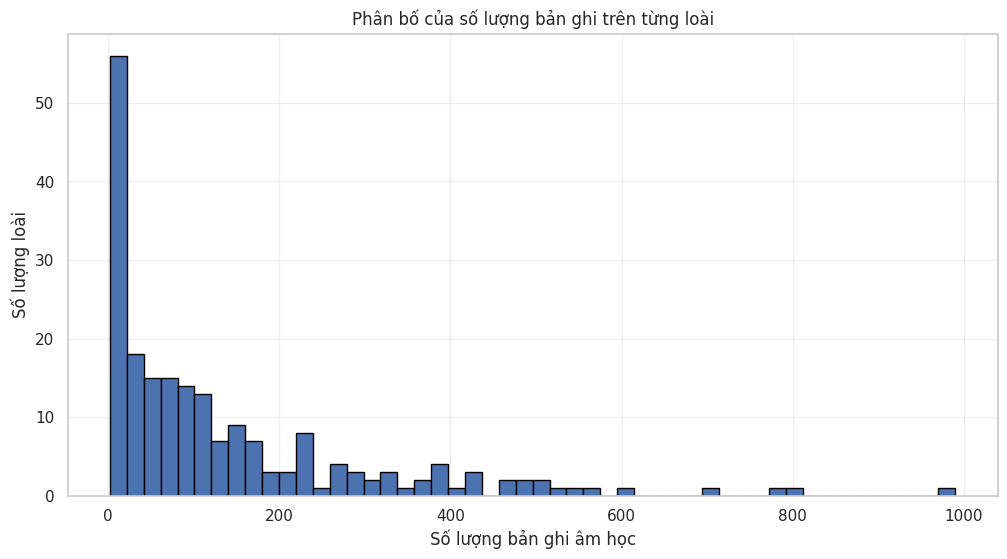

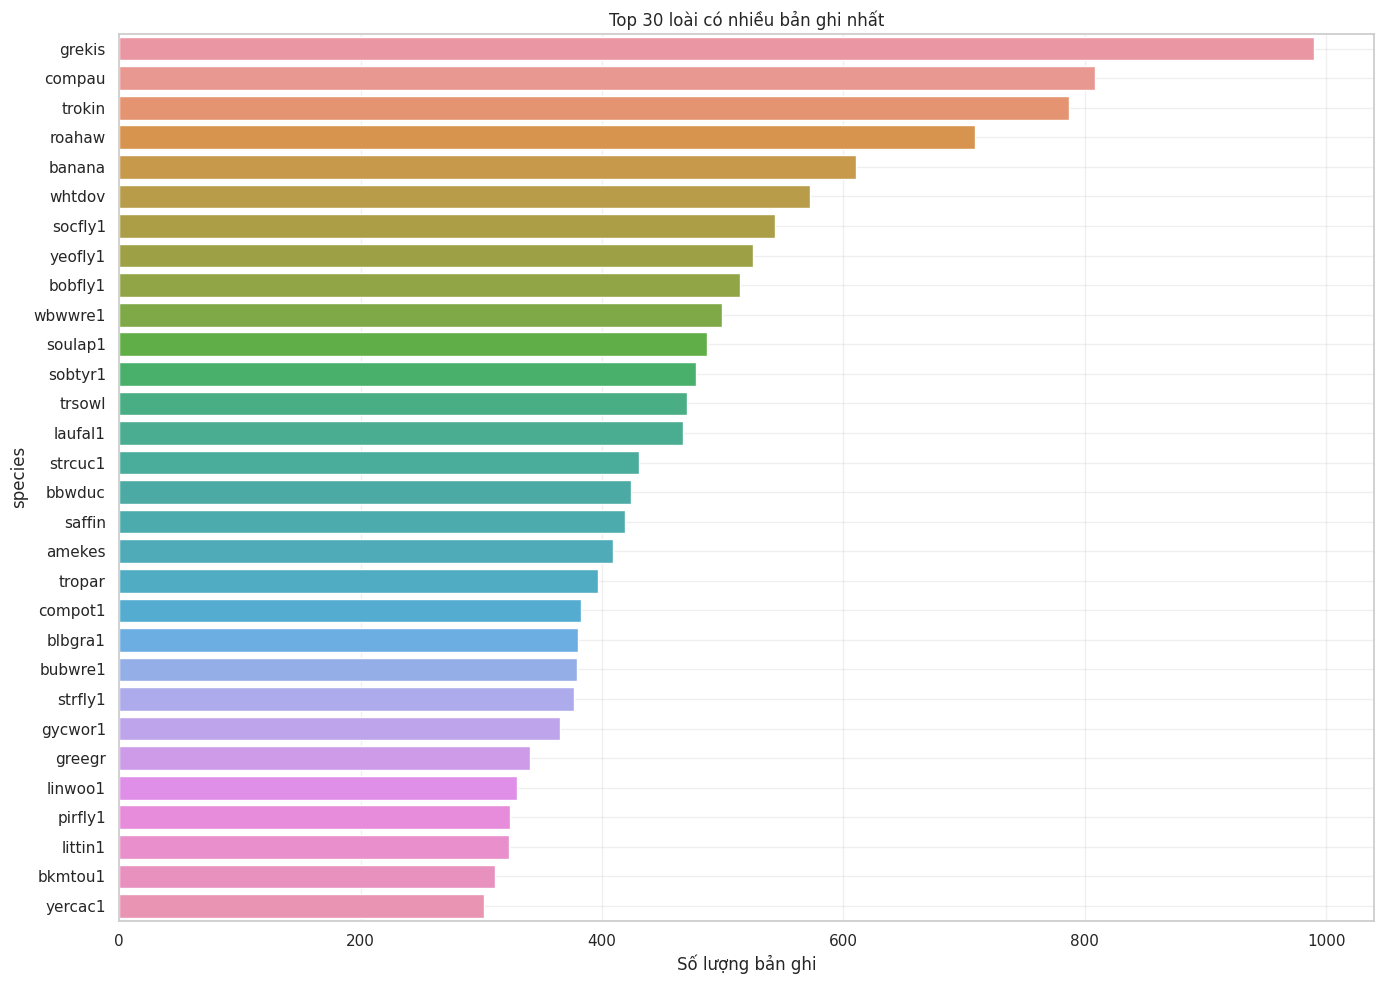

In [ ]:
# Plot phân bố 
plt.figure(figsize=(12, 6))
plt.hist(samples_df['sample_count'], bins=50, edgecolor='black')
plt.title('Phân bố của số lượng bản ghi trên từng loài')
plt.xlabel('Số lượng bản ghi âm học')
plt.ylabel('Số lượng loài')
plt.grid(True, alpha=0.3)
plt.show()

# Plot top 30 
plt.figure(figsize=(14, 10))
top_species = samples_df.head(30)
sns.barplot(x='sample_count', y='species', data=top_species)
plt.title('Top 30 loài có nhiều bản ghi nhất')
plt.xlabel('Số lượng bản ghi')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Audio Length Analysis

Analyzing audio lengths for 206 species


Species 1/206:   0%|          | 0/2 [00:00<?, ?it/s]

Species 2/206:   0%|          | 0/4 [00:00<?, ?it/s]

Species 3/206:   0%|          | 0/3 [00:00<?, ?it/s]

Species 4/206:   0%|          | 0/6 [00:00<?, ?it/s]

Species 5/206:   0%|          | 0/5 [00:00<?, ?it/s]

Species 6/206:   0%|          | 0/4 [00:00<?, ?it/s]

Species 7/206:   0%|          | 0/10 [00:00<?, ?it/s]

Species 8/206:   0%|          | 0/3 [00:00<?, ?it/s]

Species 9/206:   0%|          | 0/7 [00:00<?, ?it/s]

Species 10/206:   0%|          | 0/6 [00:00<?, ?it/s]

Species 11/206:   0%|          | 0/2 [00:00<?, ?it/s]

Species 12/206:   0%|          | 0/2 [00:00<?, ?it/s]

Species 13/206:   0%|          | 0/76 [00:00<?, ?it/s]

Species 14/206:   0%|          | 0/47 [00:00<?, ?it/s]

Species 15/206:   0%|          | 0/53 [00:00<?, ?it/s]

Species 16/206:   0%|          | 0/44 [00:00<?, ?it/s]

Species 17/206:   0%|          | 0/6 [00:00<?, ?it/s]

Species 18/206:   0%|          | 0/3 [00:00<?, ?it/s]

Species 19/206:   0%|          | 0/13 [00:00<?, ?it/s]

Species 20/206:   0%|          | 0/108 [00:00<?, ?it/s]

Species 21/206:   0%|          | 0/2 [00:00<?, ?it/s]

Species 22/206:   0%|          | 0/15 [00:00<?, ?it/s]

Species 23/206:   0%|          | 0/19 [00:00<?, ?it/s]

Species 24/206:   0%|          | 0/2 [00:00<?, ?it/s]

Species 25/206:   0%|          | 0/2 [00:00<?, ?it/s]

Species 26/206:   0%|          | 0/5 [00:00<?, ?it/s]

Species 27/206:   0%|          | 0/2 [00:00<?, ?it/s]

Species 28/206:   0%|          | 0/2 [00:00<?, ?it/s]

Species 29/206:   0%|          | 0/5 [00:00<?, ?it/s]

Species 30/206:   0%|          | 0/20 [00:00<?, ?it/s]

Species 31/206:   0%|          | 0/30 [00:00<?, ?it/s]

Species 32/206:   0%|          | 0/58 [00:00<?, ?it/s]

Species 33/206:   0%|          | 0/4 [00:00<?, ?it/s]

Species 34/206:   0%|          | 0/2 [00:00<?, ?it/s]

Species 35/206:   0%|          | 0/33 [00:00<?, ?it/s]

Species 36/206:   0%|          | 0/5 [00:00<?, ?it/s]

Species 37/206:   0%|          | 0/25 [00:00<?, ?it/s]

Species 38/206:   0%|          | 0/6 [00:00<?, ?it/s]

Species 39/206:   0%|          | 0/23 [00:00<?, ?it/s]

Species 40/206:   0%|          | 0/2 [00:00<?, ?it/s]

Species 41/206:   0%|          | 0/6 [00:00<?, ?it/s]

Species 42/206:   0%|          | 0/16 [00:00<?, ?it/s]

Species 43/206:   0%|          | 0/16 [00:00<?, ?it/s]

Species 44/206:   0%|          | 0/32 [00:00<?, ?it/s]

Species 45/206:   0%|          | 0/3 [00:00<?, ?it/s]

Species 46/206:   0%|          | 0/82 [00:00<?, ?it/s]

Species 47/206:   0%|          | 0/7 [00:00<?, ?it/s]

Species 48/206:   0%|          | 0/21 [00:00<?, ?it/s]

Species 49/206:   0%|          | 0/2 [00:00<?, ?it/s]

Species 50/206:   0%|          | 0/2 [00:00<?, ?it/s]

Species 51/206:   0%|          | 0/2 [00:00<?, ?it/s]

Species 52/206:   0%|          | 0/5 [00:00<?, ?it/s]

Species 53/206:   0%|          | 0/2 [00:00<?, ?it/s]

Species 54/206:   0%|          | 0/14 [00:00<?, ?it/s]

Species 55/206:   0%|          | 0/5 [00:00<?, ?it/s]

Species 56/206:   0%|          | 0/17 [00:00<?, ?it/s]

Species 57/206:   0%|          | 0/7 [00:00<?, ?it/s]

Species 58/206:   0%|          | 0/2 [00:00<?, ?it/s]

Species 59/206:   0%|          | 0/4 [00:00<?, ?it/s]

Species 60/206:   0%|          | 0/5 [00:00<?, ?it/s]

Species 61/206:   0%|          | 0/89 [00:00<?, ?it/s]

Species 62/206:   0%|          | 0/409 [00:00<?, ?it/s]

Species 63/206:   0%|          | 0/28 [00:00<?, ?it/s]

Species 64/206:   0%|          | 0/91 [00:00<?, ?it/s]

Species 65/206:   0%|          | 0/167 [00:00<?, ?it/s]

Species 66/206:   0%|          | 0/27 [00:00<?, ?it/s]

Species 67/206:   0%|          | 0/610 [00:00<?, ?it/s]

Species 68/206:   0%|          | 0/149 [00:00<?, ?it/s]

Species 69/206:   0%|          | 0/424 [00:00<?, ?it/s]

Species 70/206:   0%|          | 0/93 [00:00<?, ?it/s]

Species 71/206:   0%|          | 0/176 [00:00<?, ?it/s]

Species 72/206:   0%|          | 0/311 [00:00<?, ?it/s]

Species 73/206:   0%|          | 0/380 [00:00<?, ?it/s]

Species 74/206:   0%|          | 0/110 [00:00<?, ?it/s]

Species 75/206:   0%|          | 0/105 [00:00<?, ?it/s]

Species 76/206:   0%|          | 0/54 [00:00<?, ?it/s]

Species 77/206:   0%|          | 0/108 [00:00<?, ?it/s]

Species 78/206:   0%|          | 0/32 [00:00<?, ?it/s]

Species 79/206:   0%|          | 0/230 [00:00<?, ?it/s]

Species 80/206:   0%|          | 0/70 [00:00<?, ?it/s]

Species 81/206:   0%|          | 0/514 [00:00<?, ?it/s]

Species 82/206:   0%|          | 0/39 [00:00<?, ?it/s]

Species 83/206:   0%|          | 0/74 [00:00<?, ?it/s]

Species 84/206:   0%|          | 0/20 [00:00<?, ?it/s]

Species 85/206:   0%|          | 0/379 [00:00<?, ?it/s]

Species 86/206:   0%|          | 0/47 [00:00<?, ?it/s]

Species 87/206:   0%|          | 0/280 [00:00<?, ?it/s]

Species 88/206:   0%|          | 0/298 [00:00<?, ?it/s]

Species 89/206:   0%|          | 0/94 [00:00<?, ?it/s]

Species 90/206:   0%|          | 0/114 [00:00<?, ?it/s]

Species 91/206:   0%|          | 0/270 [00:00<?, ?it/s]

Species 92/206:   0%|          | 0/139 [00:00<?, ?it/s]

Species 93/206:   0%|          | 0/67 [00:00<?, ?it/s]

Species 94/206:   0%|          | 0/40 [00:00<?, ?it/s]

Species 95/206:   0%|          | 0/162 [00:00<?, ?it/s]

Species 96/206:   0%|          | 0/57 [00:00<?, ?it/s]

Species 97/206:   0%|          | 0/145 [00:00<?, ?it/s]

Species 98/206:   0%|          | 0/808 [00:00<?, ?it/s]

Species 99/206:   0%|          | 0/383 [00:00<?, ?it/s]

Species 100/206:   0%|          | 0/260 [00:00<?, ?it/s]

Species 101/206:   0%|          | 0/56 [00:00<?, ?it/s]

Species 102/206:   0%|          | 0/144 [00:00<?, ?it/s]

Species 103/206:   0%|          | 0/50 [00:00<?, ?it/s]

Species 104/206:   0%|          | 0/77 [00:00<?, ?it/s]

Species 105/206:   0%|          | 0/229 [00:00<?, ?it/s]

Species 106/206:   0%|          | 0/105 [00:00<?, ?it/s]

Species 107/206:   0%|          | 0/80 [00:00<?, ?it/s]

Species 108/206:   0%|          | 0/134 [00:00<?, ?it/s]

Species 109/206:   0%|          | 0/85 [00:00<?, ?it/s]

Species 110/206:   0%|          | 0/107 [00:00<?, ?it/s]

Species 111/206:   0%|          | 0/127 [00:00<?, ?it/s]

Species 112/206:   0%|          | 0/340 [00:00<?, ?it/s]

Species 113/206:   0%|          | 0/109 [00:00<?, ?it/s]

Species 114/206:   0%|          | 0/990 [00:00<?, ?it/s]

Species 115/206:   0%|          | 0/67 [00:00<?, ?it/s]

Species 116/206:   0%|          | 0/83 [00:00<?, ?it/s]

Species 117/206:   0%|          | 0/132 [00:00<?, ?it/s]

Species 118/206:   0%|          | 0/25 [00:00<?, ?it/s]

Species 119/206:   0%|          | 0/164 [00:00<?, ?it/s]

Species 120/206:   0%|          | 0/365 [00:00<?, ?it/s]

Species 121/206:   0%|          | 0/67 [00:00<?, ?it/s]

Species 122/206:   0%|          | 0/467 [00:00<?, ?it/s]

Species 123/206:   0%|          | 0/108 [00:00<?, ?it/s]

Species 124/206:   0%|          | 0/330 [00:00<?, ?it/s]

Species 125/206:   0%|          | 0/323 [00:00<?, ?it/s]

Species 126/206:   0%|          | 0/109 [00:00<?, ?it/s]

Species 127/206:   0%|          | 0/90 [00:00<?, ?it/s]

Species 128/206:   0%|          | 0/14 [00:00<?, ?it/s]

Species 129/206:   0%|          | 0/38 [00:00<?, ?it/s]

Species 130/206:   0%|          | 0/218 [00:00<?, ?it/s]

Species 131/206:   0%|          | 0/66 [00:00<?, ?it/s]

Species 132/206:   0%|          | 0/224 [00:00<?, ?it/s]

Species 133/206:   0%|          | 0/151 [00:00<?, ?it/s]

Species 134/206:   0%|          | 0/55 [00:00<?, ?it/s]

Species 135/206:   0%|          | 0/324 [00:00<?, ?it/s]

Species 136/206:   0%|          | 0/19 [00:00<?, ?it/s]

Species 137/206:   0%|          | 0/186 [00:00<?, ?it/s]

Species 138/206:   0%|          | 0/6 [00:00<?, ?it/s]

Species 139/206:   0%|          | 0/38 [00:00<?, ?it/s]

Species 140/206:   0%|          | 0/147 [00:00<?, ?it/s]

Species 141/206:   0%|          | 0/89 [00:00<?, ?it/s]

Species 142/206:   0%|          | 0/55 [00:00<?, ?it/s]

Species 143/206:   0%|          | 0/90 [00:00<?, ?it/s]

Species 144/206:   0%|          | 0/222 [00:00<?, ?it/s]

Species 145/206:   0%|          | 0/709 [00:00<?, ?it/s]

Species 146/206:   0%|          | 0/34 [00:00<?, ?it/s]

Species 147/206:   0%|          | 0/40 [00:00<?, ?it/s]

Species 148/206:   0%|          | 0/148 [00:00<?, ?it/s]

Species 149/206:   0%|          | 0/70 [00:00<?, ?it/s]

Species 150/206:   0%|          | 0/97 [00:00<?, ?it/s]

Species 151/206:   0%|          | 0/138 [00:00<?, ?it/s]

Species 152/206:   0%|          | 0/236 [00:00<?, ?it/s]

Species 153/206:   0%|          | 0/80 [00:00<?, ?it/s]

Species 154/206:   0%|          | 0/261 [00:00<?, ?it/s]

Species 155/206:   0%|          | 0/17 [00:00<?, ?it/s]

Species 156/206:   0%|          | 0/419 [00:00<?, ?it/s]

Species 157/206:   0%|          | 0/14 [00:00<?, ?it/s]

Species 158/206:   0%|          | 0/54 [00:00<?, ?it/s]

Species 159/206:   0%|          | 0/158 [00:00<?, ?it/s]

Species 160/206:   0%|          | 0/15 [00:00<?, ?it/s]

Species 161/206:   0%|          | 0/90 [00:00<?, ?it/s]

Species 162/206:   0%|          | 0/287 [00:00<?, ?it/s]

Species 163/206:   0%|          | 0/108 [00:00<?, ?it/s]

Species 164/206:   0%|          | 0/478 [00:00<?, ?it/s]

Species 165/206:   0%|          | 0/543 [00:00<?, ?it/s]

Species 166/206:   0%|          | 0/237 [00:00<?, ?it/s]

Species 167/206:   0%|          | 0/487 [00:00<?, ?it/s]

Species 168/206:   0%|          | 0/48 [00:00<?, ?it/s]

Species 169/206:   0%|          | 0/201 [00:00<?, ?it/s]

Species 170/206:   0%|          | 0/81 [00:00<?, ?it/s]

Species 171/206:   0%|          | 0/112 [00:00<?, ?it/s]

Species 172/206:   0%|          | 0/210 [00:00<?, ?it/s]

Species 173/206:   0%|          | 0/431 [00:00<?, ?it/s]

Species 174/206:   0%|          | 0/377 [00:00<?, ?it/s]

Species 175/206:   0%|          | 0/169 [00:00<?, ?it/s]

Species 176/206:   0%|          | 0/164 [00:00<?, ?it/s]

Species 177/206:   0%|          | 0/40 [00:00<?, ?it/s]

Species 178/206:   0%|          | 0/153 [00:00<?, ?it/s]

Species 179/206:   0%|          | 0/97 [00:00<?, ?it/s]

Species 180/206:   0%|          | 0/787 [00:00<?, ?it/s]

Species 181/206:   0%|          | 0/397 [00:00<?, ?it/s]

Species 182/206:   0%|          | 0/470 [00:00<?, ?it/s]

Species 183/206:   0%|          | 0/11 [00:00<?, ?it/s]

Species 184/206:   0%|          | 0/69 [00:00<?, ?it/s]

Species 185/206:   0%|          | 0/133 [00:00<?, ?it/s]

Species 186/206:   0%|          | 0/499 [00:00<?, ?it/s]

Species 187/206:   0%|          | 0/104 [00:00<?, ?it/s]

Species 188/206:   0%|          | 0/246 [00:00<?, ?it/s]

Species 189/206:   0%|          | 0/126 [00:00<?, ?it/s]

Species 190/206:   0%|          | 0/34 [00:00<?, ?it/s]

Species 191/206:   0%|          | 0/572 [00:00<?, ?it/s]

Species 192/206:   0%|          | 0/75 [00:00<?, ?it/s]

Species 193/206:   0%|          | 0/50 [00:00<?, ?it/s]

Species 194/206:   0%|          | 0/27 [00:00<?, ?it/s]

Species 195/206:   0%|          | 0/169 [00:00<?, ?it/s]

Species 196/206:   0%|          | 0/267 [00:00<?, ?it/s]

Species 197/206:   0%|          | 0/188 [00:00<?, ?it/s]

Species 198/206:   0%|          | 0/185 [00:00<?, ?it/s]

Species 199/206:   0%|          | 0/235 [00:00<?, ?it/s]

Species 200/206:   0%|          | 0/97 [00:00<?, ?it/s]

Species 201/206:   0%|          | 0/79 [00:00<?, ?it/s]

Species 202/206:   0%|          | 0/238 [00:00<?, ?it/s]

Species 203/206:   0%|          | 0/60 [00:00<?, ?it/s]

Species 204/206:   0%|          | 0/525 [00:00<?, ?it/s]

Species 205/206:   0%|          | 0/302 [00:00<?, ?it/s]

Species 206/206:   0%|          | 0/142 [00:00<?, ?it/s]


Audio Length Statistics:
- Number of files analyzed: 28564
- Average length: 35.35 seconds
- Min length: 0.54 seconds
- Max length: 1774.39 seconds
- Median length: 20.98 seconds


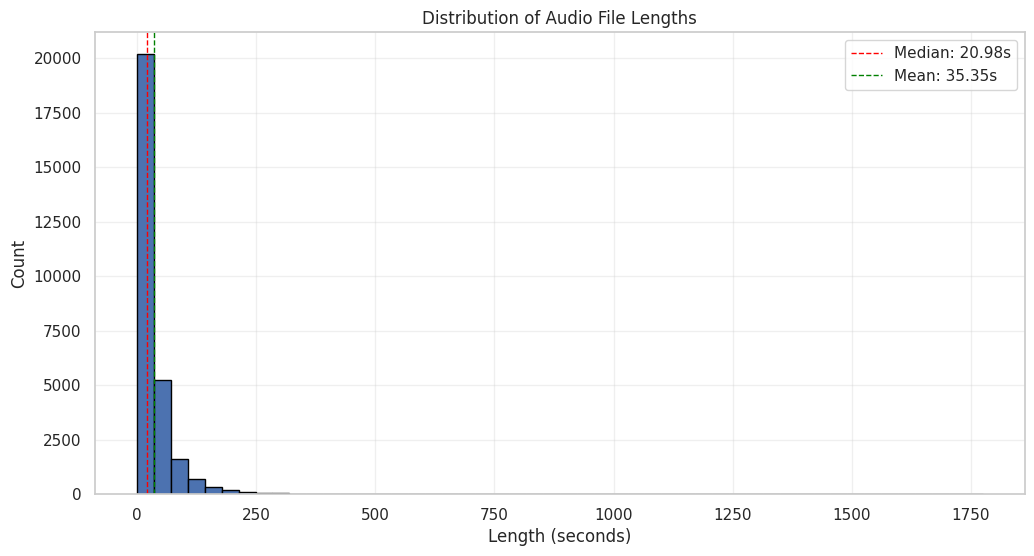

In [ ]:
def analyze_audio_length(species_list, species_dir_mapping, cfg):
    results = {
        'audio_lengths': [],
        'species_lengths': {}
    }
    if cfg.DEBUG_MODE:
        np.random.seed(42)
        if len(species_list) > 20:  #lấy 20 loài nếu test
            species_subset = np.random.choice(species_list, 20, replace=False).tolist()
        else:
            species_subset = species_list
    else:
        species_subset = species_list
    
    print(f"Analyzing audio lengths for {len(species_subset)} species")
    
    for species_idx, species in enumerate(species_subset):
        # Lấy thư mục loài
        species_dir = species_dir_mapping.get(species)
        if not species_dir or not os.path.exists(species_dir):
            continue
        
        # Lấy file bản ghi từng loài
        audio_files = [f for f in os.listdir(species_dir) 
                     if f.endswith(('.mp3', '.ogg', '.wav'))]
        
        if cfg.DEBUG_MODE:
            if len(audio_files) > cfg.SAMPLE_SIZE:
                audio_files = np.random.choice(audio_files, cfg.SAMPLE_SIZE, replace=False).tolist()
        
        species_lengths = []
        
        # Xử lý file
        for file_idx, filename in enumerate(tqdm(audio_files, desc=f"Species {species_idx+1}/{len(species_subset)}")):
            file_path = os.path.join(species_dir, filename)
            
            # Load và phân tích file
            audio = load_audio_file(file_path, sr=cfg.SR)
            
            if audio is not None:
                # Tính toán thời lượng
                audio_length = len(audio) / cfg.SR
                results['audio_lengths'].append(audio_length)
                species_lengths.append(audio_length)
        
        # Lưu trữ lại
        if species_lengths:
            results['species_lengths'][species] = species_lengths
            
    return results

audio_length_results = analyze_audio_length(species_list, species_dir_mapping, cfg)

if audio_length_results['audio_lengths']:
    audio_lengths = np.array(audio_length_results['audio_lengths'])
    
    print("\nAudio Length Statistics:")
    print(f"- Number of files analyzed: {len(audio_lengths)}")
    print(f"- Average length: {np.mean(audio_lengths):.2f} seconds")
    print(f"- Min length: {np.min(audio_lengths):.2f} seconds")
    print(f"- Max length: {np.max(audio_lengths):.2f} seconds")
    print(f"- Median length: {np.median(audio_lengths):.2f} seconds")
    
    # Plot biểu đồ phân bố thời lượng của bản ghi
    plt.figure(figsize=(12, 6))
    plt.hist(audio_lengths, bins=50, edgecolor='black')
    plt.axvline(np.median(audio_lengths), color='red', linestyle='dashed', 
                linewidth=1, label=f'Median: {np.median(audio_lengths):.2f}s')
    plt.axvline(np.mean(audio_lengths), color='green', linestyle='dashed', 
                linewidth=1, label=f'Mean: {np.mean(audio_lengths):.2f}s')
    plt.title('Distribution of Audio File Lengths')
    plt.xlabel('Length (seconds)')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
else:
    print("No audio files were analyzed for length")

## Audio Length Distribution by Species

Species with longest average audio:


,species,avg_length
27,476537,226.956000
10,21038,196.719000
39,64862,196.452000
34,52884,182.860768
17,24292,147.608000
30,50186,141.961078
29,48124,128.350042
6,135045,127.702656
33,528041,106.725516
1,1192948,105.437609


Species with shortest average audio:


,species,avg_length
42,65349,14.893062
174,strher,14.415108
48,66016,13.428000
24,42113,11.326203
23,42087,10.566047
11,21116,6.527750
32,523060,6.103398
58,868458,5.890055
35,548639,5.848350
9,1564122,1.888344


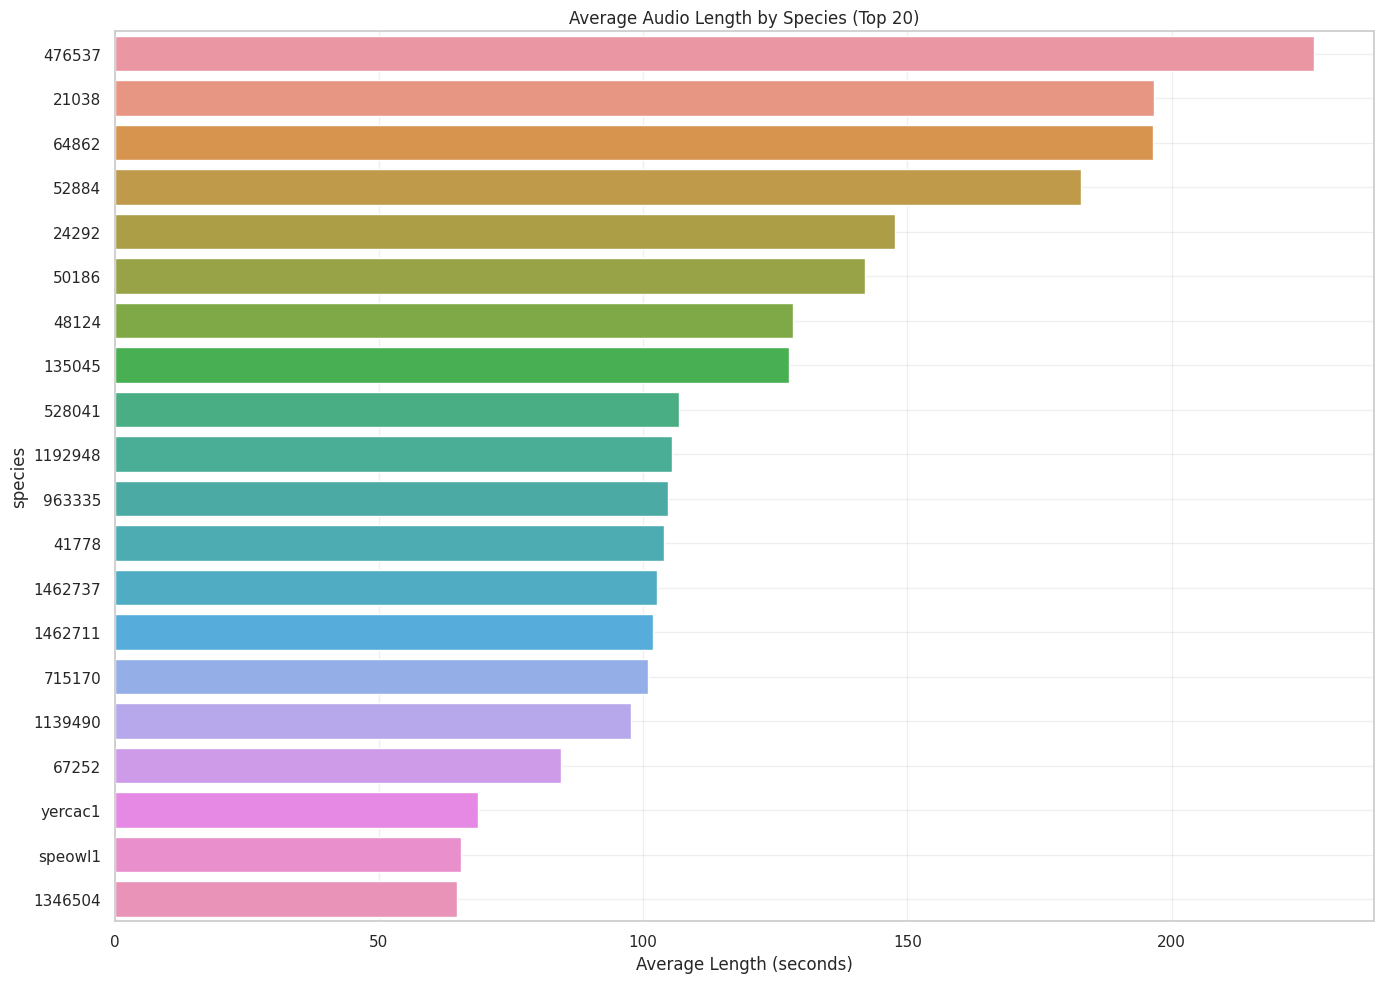

In [ ]:
# Thời lượng trung bình
if audio_length_results['species_lengths']:
    species_avg_lengths = {
        species: np.mean(lengths)
        for species, lengths in audio_length_results['species_lengths'].items()
        if lengths
    }
    
    # Chuyển sang datafrmae
    species_length_df = pd.DataFrame({
        'species': list(species_avg_lengths.keys()),
        'avg_length': list(species_avg_lengths.values())
    }).sort_values('avg_length', ascending=False)
    
    # Danh sách các loài có thời lượng bản ghi trung bình dài nhất và ngắn nhất
    print("Species with longest average audio:")
    display(species_length_df.head(10))
    
    print("Species with shortest average audio:")
    display(species_length_df.tail(10))
    
    # Plot dữ liệu
    plt.figure(figsize=(14, 10))
    sns.barplot(x='avg_length', y='species', data=species_length_df.head(20))
    plt.title('Average Audio Length by Species (Top 20)')
    plt.xlabel('Average Length (seconds)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Audio Quality Analysis

Khảo sát chất lượng các bản ghi


Quality Rating Statistics:


count    28564.000000
mean         2.917063
std          1.964896
min          0.000000
25%          0.000000
50%          4.000000
75%          4.500000
max          5.000000
Name: rating, dtype: float64


Count of each rating value:


rating
0.0    7948
0.5      26
1.0     228
1.5      70
2.0     752
2.5     360
3.0    2886
3.5     895
4.0    7582
4.5    1261
5.0    6556
Name: count, dtype: int64

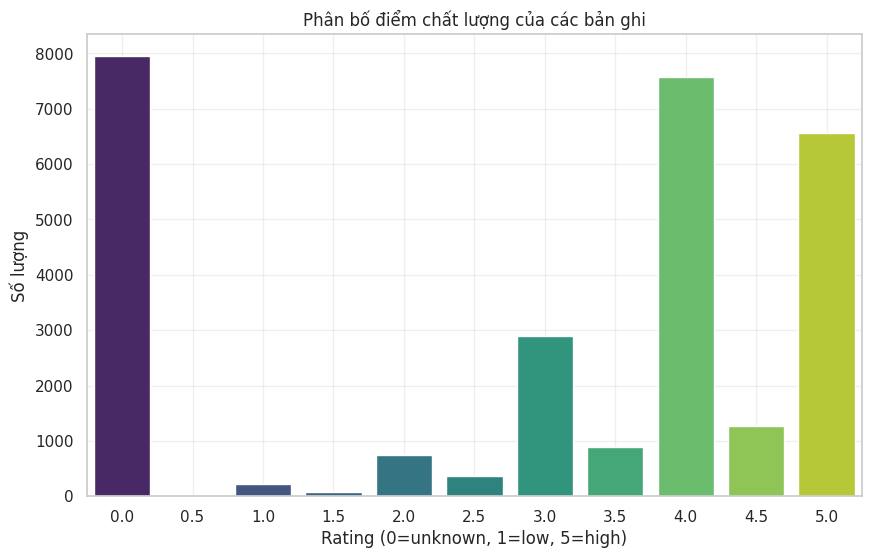


Species with highest average quality rating:


,primary_label,mean,count
159,shghum1,4.166667,15
197,yebsee1,4.089189,185
178,thlsch3,4.015464,97
101,crcwoo1,3.975694,144
171,stbwoo2,3.961905,210
147,rtlhum,3.932432,148
93,cocher1,3.925000,40
70,bkcdon,3.900568,176
136,plbwoo1,3.887097,186
87,butsal1,3.879195,298



Species with lowest average quality rating:


,primary_label,mean,count
22,42007,0.0,19
17,24292,0.0,3
55,715170,0.0,17
32,523060,0.0,4
56,787625,0.0,7
57,81930,0.0,2
58,868458,0.0,4
59,963335,0.0,5
27,476537,0.0,2
0,1139490,0.0,2


Analyzing computed quality for 206 species


Computing quality for 1139490:   0%|          | 0/2 [00:00<?, ?it/s]

Computing quality for 1192948:   0%|          | 0/4 [00:00<?, ?it/s]

Computing quality for 1194042:   0%|          | 0/3 [00:00<?, ?it/s]

Computing quality for 126247:   0%|          | 0/6 [00:00<?, ?it/s]

Computing quality for 1346504:   0%|          | 0/5 [00:00<?, ?it/s]

Computing quality for 134933:   0%|          | 0/4 [00:00<?, ?it/s]

Computing quality for 135045:   0%|          | 0/10 [00:00<?, ?it/s]

Computing quality for 1462711:   0%|          | 0/3 [00:00<?, ?it/s]

Computing quality for 1462737:   0%|          | 0/7 [00:00<?, ?it/s]

Computing quality for 1564122:   0%|          | 0/6 [00:00<?, ?it/s]

Computing quality for 21038:   0%|          | 0/2 [00:00<?, ?it/s]

Computing quality for 21116:   0%|          | 0/2 [00:00<?, ?it/s]

Computing quality for 21211:   0%|          | 0/76 [00:00<?, ?it/s]

Computing quality for 22333:   0%|          | 0/47 [00:00<?, ?it/s]

Computing quality for 22973:   0%|          | 0/53 [00:00<?, ?it/s]

Computing quality for 22976:   0%|          | 0/44 [00:00<?, ?it/s]

Computing quality for 24272:   0%|          | 0/6 [00:00<?, ?it/s]

Computing quality for 24292:   0%|          | 0/3 [00:00<?, ?it/s]

Computing quality for 24322:   0%|          | 0/13 [00:00<?, ?it/s]

Computing quality for 41663:   0%|          | 0/108 [00:00<?, ?it/s]

Computing quality for 41778:   0%|          | 0/2 [00:00<?, ?it/s]

Computing quality for 41970:   0%|          | 0/15 [00:00<?, ?it/s]

Computing quality for 42007:   0%|          | 0/19 [00:00<?, ?it/s]

Computing quality for 42087:   0%|          | 0/2 [00:00<?, ?it/s]

Computing quality for 42113:   0%|          | 0/2 [00:00<?, ?it/s]

Computing quality for 46010:   0%|          | 0/5 [00:00<?, ?it/s]

Computing quality for 47067:   0%|          | 0/2 [00:00<?, ?it/s]

Computing quality for 476537:   0%|          | 0/2 [00:00<?, ?it/s]

Computing quality for 476538:   0%|          | 0/5 [00:00<?, ?it/s]

Computing quality for 48124:   0%|          | 0/20 [00:00<?, ?it/s]

Computing quality for 50186:   0%|          | 0/30 [00:00<?, ?it/s]

Computing quality for 517119:   0%|          | 0/58 [00:00<?, ?it/s]

Computing quality for 523060:   0%|          | 0/4 [00:00<?, ?it/s]

Computing quality for 528041:   0%|          | 0/2 [00:00<?, ?it/s]

Computing quality for 52884:   0%|          | 0/33 [00:00<?, ?it/s]

Computing quality for 548639:   0%|          | 0/5 [00:00<?, ?it/s]

Computing quality for 555086:   0%|          | 0/25 [00:00<?, ?it/s]

Computing quality for 555142:   0%|          | 0/6 [00:00<?, ?it/s]

Computing quality for 566513:   0%|          | 0/23 [00:00<?, ?it/s]

Computing quality for 64862:   0%|          | 0/2 [00:00<?, ?it/s]

Computing quality for 65336:   0%|          | 0/6 [00:00<?, ?it/s]

Computing quality for 65344:   0%|          | 0/16 [00:00<?, ?it/s]

Computing quality for 65349:   0%|          | 0/16 [00:00<?, ?it/s]

Computing quality for 65373:   0%|          | 0/32 [00:00<?, ?it/s]

Computing quality for 65419:   0%|          | 0/3 [00:00<?, ?it/s]

Computing quality for 65448:   0%|          | 0/82 [00:00<?, ?it/s]

Computing quality for 65547:   0%|          | 0/7 [00:00<?, ?it/s]

Computing quality for 65962:   0%|          | 0/21 [00:00<?, ?it/s]

Computing quality for 66016:   0%|          | 0/2 [00:00<?, ?it/s]

Computing quality for 66531:   0%|          | 0/2 [00:00<?, ?it/s]

Computing quality for 66578:   0%|          | 0/2 [00:00<?, ?it/s]

Computing quality for 66893:   0%|          | 0/5 [00:00<?, ?it/s]

Computing quality for 67082:   0%|          | 0/2 [00:00<?, ?it/s]

Computing quality for 67252:   0%|          | 0/14 [00:00<?, ?it/s]

Computing quality for 714022:   0%|          | 0/5 [00:00<?, ?it/s]

Computing quality for 715170:   0%|          | 0/17 [00:00<?, ?it/s]

Computing quality for 787625:   0%|          | 0/7 [00:00<?, ?it/s]

Computing quality for 81930:   0%|          | 0/2 [00:00<?, ?it/s]

Computing quality for 868458:   0%|          | 0/4 [00:00<?, ?it/s]

Computing quality for 963335:   0%|          | 0/5 [00:00<?, ?it/s]

Computing quality for amakin1:   0%|          | 0/89 [00:00<?, ?it/s]

Computing quality for amekes:   0%|          | 0/409 [00:00<?, ?it/s]

Computing quality for ampkin1:   0%|          | 0/28 [00:00<?, ?it/s]

Computing quality for anhing:   0%|          | 0/91 [00:00<?, ?it/s]

Computing quality for babwar:   0%|          | 0/167 [00:00<?, ?it/s]

Computing quality for bafibi1:   0%|          | 0/27 [00:00<?, ?it/s]

Computing quality for banana:   0%|          | 0/610 [00:00<?, ?it/s]

Computing quality for baymac:   0%|          | 0/149 [00:00<?, ?it/s]

Computing quality for bbwduc:   0%|          | 0/424 [00:00<?, ?it/s]

Computing quality for bicwre1:   0%|          | 0/93 [00:00<?, ?it/s]

Computing quality for bkcdon:   0%|          | 0/176 [00:00<?, ?it/s]

Computing quality for bkmtou1:   0%|          | 0/311 [00:00<?, ?it/s]

Computing quality for blbgra1:   0%|          | 0/380 [00:00<?, ?it/s]

Computing quality for blbwre1:   0%|          | 0/110 [00:00<?, ?it/s]

Computing quality for blcant4:   0%|          | 0/105 [00:00<?, ?it/s]

Computing quality for blchaw1:   0%|          | 0/54 [00:00<?, ?it/s]

Computing quality for blcjay1:   0%|          | 0/108 [00:00<?, ?it/s]

Computing quality for blctit1:   0%|          | 0/32 [00:00<?, ?it/s]

Computing quality for blhpar1:   0%|          | 0/230 [00:00<?, ?it/s]

Computing quality for blkvul:   0%|          | 0/70 [00:00<?, ?it/s]

Computing quality for bobfly1:   0%|          | 0/514 [00:00<?, ?it/s]

Computing quality for bobher1:   0%|          | 0/39 [00:00<?, ?it/s]

Computing quality for brtpar1:   0%|          | 0/74 [00:00<?, ?it/s]

Computing quality for bubcur1:   0%|          | 0/20 [00:00<?, ?it/s]

Computing quality for bubwre1:   0%|          | 0/379 [00:00<?, ?it/s]

Computing quality for bucmot3:   0%|          | 0/47 [00:00<?, ?it/s]

Computing quality for bugtan:   0%|          | 0/280 [00:00<?, ?it/s]

Computing quality for butsal1:   0%|          | 0/298 [00:00<?, ?it/s]

Computing quality for cargra1:   0%|          | 0/94 [00:00<?, ?it/s]

Computing quality for cattyr:   0%|          | 0/114 [00:00<?, ?it/s]

Computing quality for chbant1:   0%|          | 0/270 [00:00<?, ?it/s]

Computing quality for chfmac1:   0%|          | 0/139 [00:00<?, ?it/s]

Computing quality for cinbec1:   0%|          | 0/67 [00:00<?, ?it/s]

In [ ]:
def analyze_quality_ratings(metadata_df):
    if metadata_df is None or 'rating' not in metadata_df.columns:
        print("No quality ratings available in metadata")
        return None
    
    # Load điểm chất lượng
    quality_stats = metadata_df['rating'].describe()
    print("\nQuality Rating Statistics:")
    display(quality_stats)
    
    # Đếm số lượng điểm chất lượng
    rating_counts = metadata_df['rating'].value_counts().sort_index()
    print("\nCount of each rating value:")
    display(rating_counts)
    
    # Plot dữ liệu
    plt.figure(figsize=(10, 6))
    sns.countplot(x='rating', data=metadata_df, palette='viridis')
    plt.title('Phân bố điểm chất lượng của các bản ghi')
    plt.xlabel('Rating (0=unknown, 1=low, 5=high)')
    plt.ylabel('Số lượng')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Chất lượng trung bình của các bản ghi của các loài
    species_ratings = metadata_df.groupby('primary_label')['rating'].agg(['mean', 'count']).reset_index()
    species_ratings = species_ratings.sort_values('mean', ascending=False)
    
    print("\nSpecies with highest average quality rating:")
    display(species_ratings.head(10))
    
    print("\nSpecies with lowest average quality rating:")
    display(species_ratings.tail(10))
    
    return species_ratings

species_ratings = None
if metadata_df is not None:
    species_ratings = analyze_quality_ratings(metadata_df)

# Hàm đánh giá chất lượng
def analyze_computed_quality(species_list, species_dir_mapping, cfg):
    """Compute our own quality assessment on audio files"""
    results = {
        'quality_scores': [],
        'species_scores': {}
    }
    
    if cfg.DEBUG_MODE:
        if len(species_list) > 15: 
            species_subset = np.random.choice(species_list, 15, replace=False).tolist()
        else:
            species_subset = species_list
    else:
        species_subset = species_list
    
    print(f"Analyzing computed quality for {len(species_subset)} species")
    
    for species_idx, species in enumerate(species_subset):
        # Lấy thư mục 
        species_dir = species_dir_mapping.get(species)
        if not species_dir or not os.path.exists(species_dir):
            continue
        
        # Lấy file
        audio_files = [f for f in os.listdir(species_dir) 
                     if f.endswith(('.mp3', '.ogg', '.wav'))]
        
        if cfg.DEBUG_MODE:
            if len(audio_files) > cfg.SAMPLE_SIZE:
                audio_files = np.random.choice(audio_files, cfg.SAMPLE_SIZE, replace=False).tolist()
        
        species_scores = []
        
        # Xử lý file âm thanh
        for filename in tqdm(audio_files, desc=f"Computing quality for {species}"):
            file_path = os.path.join(species_dir, filename)
            
            # Load và đánh giá chất lượng
            audio = load_audio_file(file_path, sr=cfg.SR)
            
            if audio is not None:
                # Tính toán chất lượng file âm thanh
                quality = assess_audio_quality(audio)
                results['quality_scores'].append((species, filename, quality))
                species_scores.append(quality)
        
        # Lưu trữ lại
        if species_scores:
            results['species_scores'][species] = species_scores
    
    return results

computed_quality_results = analyze_computed_quality(species_list, species_dir_mapping, cfg)

if computed_quality_results['quality_scores']:
    quality_scores = [score for _, _, score in computed_quality_results['quality_scores']]
    
    print("\nComputed Quality Score Statistics:")
    print(f"- Average quality: {np.mean(quality_scores):.4f}")
    print(f"- Min quality: {np.min(quality_scores):.4f}")
    print(f"- Max quality: {np.max(quality_scores):.4f}")
    
    # Biểu diễn phân bố chất lượng
    plt.figure(figsize=(12, 6))
    plt.hist(quality_scores, bins=50, edgecolor='black')
    plt.title('Phân bố điểm chất lượng của các bản ghi')
    plt.xlabel('Điểm chất lượng')
    plt.ylabel('Số lượng')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Chất lượng trung bình
    species_quality = {}
    for species, scores in computed_quality_results['species_scores'].items():
        if scores:
            species_quality[species] = np.mean(scores)
    
    species_quality_df = pd.DataFrame({
        'species': list(species_quality.keys()),
        'avg_quality': list(species_quality.values())
    }).sort_values('avg_quality', ascending=False)
    
    # Plot chất lượng trung bình
    plt.figure(figsize=(14, 10))
    sns.barplot(x='avg_quality', y='species', data=species_quality_df)
    plt.title('Average Computed Quality Score by Species')
    plt.xlabel('Average Quality Score')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Frequency Pattern Analysis

Trực quan các file âm học

In [ ]:
def analyze_frequency_patterns(species_list, species_dir_mapping, cfg):
    """Biểu diễn âm thanh ở một số dạng khác nhau"""
    results = {
        'frequency_data': {}
    }
    
    if cfg.DEBUG_MODE:
        if len(species_list) > 10:
            species_subset = np.random.choice(species_list, 10, replace=False).tolist()
        else:
            species_subset = species_list
    else:
        species_subset = species_list
    
    print(f"Analyzing frequency patterns for {len(species_subset)} species")
    
    for species_idx, species in enumerate(species_subset):
        species_dir = species_dir_mapping.get(species)
        if not species_dir or not os.path.exists(species_dir):
            continue
        
        audio_files = [f for f in os.listdir(species_dir) 
                     if f.endswith(('.mp3', '.ogg', '.wav'))]
        
        if cfg.DEBUG_MODE:
            if len(audio_files) > cfg.SAMPLE_SIZE:
                audio_files = np.random.choice(audio_files, cfg.SAMPLE_SIZE // 2, replace=False).tolist()
        
        species_freq_data = []
        
        for filename in tqdm(audio_files, desc=f"Analyzing frequencies for {species}"):
            file_path = os.path.join(species_dir, filename)
            
            audio = load_audio_file(file_path, sr=cfg.SR)
            
            if audio is not None:
                # Trích xuất đặc trưng tần số
                freq_data = extract_frequency_characteristics(audio, sr=cfg.SR)
                if freq_data:
                    freq_data['species'] = species
                    freq_data['filename'] = filename
                    species_freq_data.append(freq_data)
        
        if species_freq_data:
            results['frequency_data'][species] = species_freq_data
    
    return results

freq_pattern_results = analyze_frequency_patterns(species_list, species_dir_mapping, cfg)

if freq_pattern_results['frequency_data']:
    species_freq_data = {}
    for species, freq_list in freq_pattern_results['frequency_data'].items():
        if freq_list:
            species_freq_data[species] = {
                'dominant_frequency': [item['dominant_frequency'] for item in freq_list],
                'spectral_centroid': [item['spectral_centroid'] for item in freq_list],
                'spectral_bandwidth': [item['spectral_bandwidth'] for item in freq_list],
                'spectral_flatness': [item['spectral_flatness'] for item in freq_list]
            }
    
    median_values = {}
    for species, freq_data in species_freq_data.items():
        median_values[species] = {
            'dominant_frequency': np.median(freq_data['dominant_frequency']),
            'spectral_centroid': np.median(freq_data['spectral_centroid']),
            'spectral_bandwidth': np.median(freq_data['spectral_bandwidth']),
            'spectral_flatness': np.median(freq_data['spectral_flatness'])
        }
    
    freq_df = pd.DataFrame.from_dict(median_values, orient='index')
    
    print("\nFrequency Characteristics by Species:")
    display(freq_df.head())
    
    for characteristic in ['dominant_frequency', 'spectral_centroid', 'spectral_bandwidth', 'spectral_flatness']:
        plt.figure(figsize=(14, 8))
        sorted_df = freq_df.sort_values(characteristic, ascending=False)
        plt.barh(range(len(sorted_df)), sorted_df[characteristic])
        plt.yticks(range(len(sorted_df)), sorted_df.index)
        plt.title(f'Median {characteristic.replace("_", " ").title()} by Species')
        plt.xlabel('Value (Hz for frequencies)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()